# CNN

In [5]:
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

ds_path = "/kaggle/input/common-voice/cv-valid-train/"

data = pd.read_csv('/kaggle/input/common-voice/cv-valid-train.csv')
data.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


In [13]:
data = data[~data['gender'].isnull()]
data = data[data['gender'].isin(['female', 'male'])]

In [16]:
data['gender'].value_counts()

gender
male      55029
female    18249
Name: count, dtype: int64

In [136]:
def feature_extraction_cnn(filename, sampling_rate=48000, n_mfcc=13, max_len=100):
    """
    Extracts MFCC features for CNN training.
    Args:
        filename (str): The audio file name.
        sampling_rate (int): Sampling rate for audio loading.
        n_mfcc (int): Number of MFCC features to extract.
        max_len (int): Maximum number of time frames to pad or truncate to.
    Returns:
        tuple: (mfcc_array, label) where mfcc_array is 2D and label is the target.
    """
    path = f"{ds_path}{filename}"
    audio, _ = librosa.load(path, sr=sampling_rate)

    # Extract MFCCs (n_mfcc x time_frames)
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=n_mfcc)
    
    # Pad or truncate to fixed length (max_len)
    if mfcc.shape[1] < max_len:
        # Pad with zeros if the sequence is shorter than max_len
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        # Truncate if the sequence is longer than max_len
        mfcc = mfcc[:, :max_len]
    
    # Normalize MFCC values
    mfcc = (mfcc - np.min(mfcc)) / (np.max(mfcc) - np.min(mfcc))
    
    # Extract label
    label = data[data['filename'] == filename].gender.values[0]
    
    return mfcc, label

# Prepare features and labels
mfcc_features = []
labels = []

for idx,filename in enumerate(data['filename']):
    print("\r", end="")
    print("{}/{}".format(idx, len(data['filename'])), end="", flush=True)
    mfcc, label = feature_extraction_cnn(filename)
    mfcc_features.append(mfcc)
    labels.append(label)


In [137]:
import pickle

# Save the features and labels
with open('mfcc_features.pkl', 'wb') as f:
    pickle.dump(mfcc_features, f)

with open('labels.pkl', 'wb') as f:
    pickle.dump(labels, f)


In [17]:
import pickle

# Load the features and labels
with open('/kaggle/input/savemfcc-cnn/SaveMFCC_CNN/mfcc_features.pkl', 'rb') as f:
    mfcc_features = pickle.load(f)

with open('/kaggle/input/savemfcc-cnn/SaveMFCC_CNN/labels.pkl', 'rb') as f:
    labels = pickle.load(f)


In [18]:
# Convert to numpy arrays for CNN input
X = np.array(mfcc_features)  # Shape: (num_samples, n_mfcc, max_len)
y = np.array(labels)

# Reshape X to add a channel dimension
X = X[..., np.newaxis]  # Shape: (num_samples, n_mfcc, max_len, 1)

# Encode labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convert 'male', 'female' -> 0, 1
y = tf.keras.utils.to_categorical(y)  # One-hot encoding for CNN output



In [19]:
# Apply SMOTE on flattened features
from imblearn.over_sampling import SMOTE
X_flat = X.reshape(X.shape[0], -1)  # Flatten to 2D: (num_samples, n_features)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_flat, y)

# Reshape X_resampled back to 4D
X_resampled = X_resampled.reshape(-1, X.shape[1], X.shape[2], X.shape[3])

# One-hot encode the labels
y_resampled = tf.keras.utils.to_categorical(y_resampled)

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
551/551 - 11s - 20ms/step - accuracy: 0.5655 - loss: 0.6814 - val_accuracy: 0.5877 - val_loss: 0.6731 - learning_rate: 0.0010
Epoch 2/100
551/551 - 5s - 10ms/step - accuracy: 0.6274 - loss: 0.6467 - val_accuracy: 0.6977 - val_loss: 0.5899 - learning_rate: 0.0010
Epoch 3/100
551/551 - 5s - 10ms/step - accuracy: 0.7300 - loss: 0.5360 - val_accuracy: 0.7486 - val_loss: 0.5030 - learning_rate: 0.0010
Epoch 4/100
551/551 - 5s - 10ms/step - accuracy: 0.7709 - loss: 0.4735 - val_accuracy: 0.7894 - val_loss: 0.4372 - learning_rate: 0.0010
Epoch 5/100
551/551 - 5s - 10ms/step - accuracy: 0.7896 - loss: 0.4397 - val_accuracy: 0.7927 - val_loss: 0.4275 - learning_rate: 0.0010
Epoch 6/100
551/551 - 5s - 10ms/step - accuracy: 0.7992 - loss: 0.4239 - val_accuracy: 0.8029 - val_loss: 0.4067 - learning_rate: 0.0010
Epoch 7/100
551/551 - 5s - 10ms/step - accuracy: 0.8066 - loss: 0.4091 - val_accuracy: 0.8039 - val_loss: 0.4067 - learning_rate: 0.0010
Epoch 8/100
551/551 - 5s - 10ms/step - a

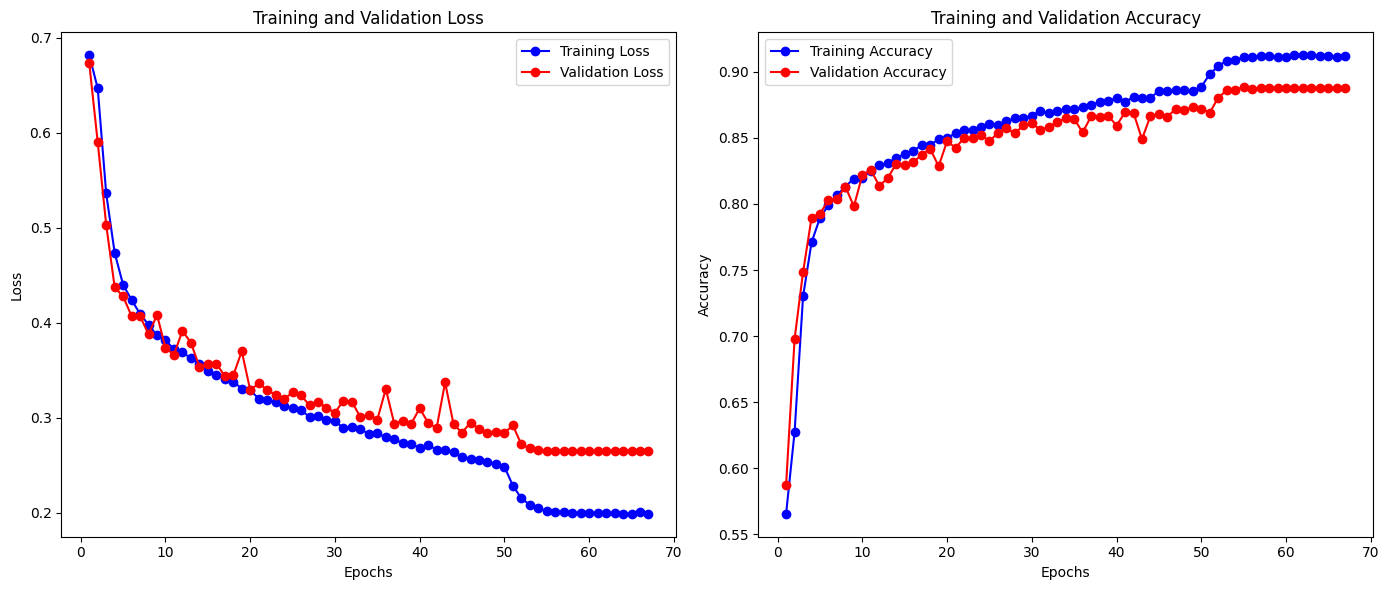

In [25]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt
import torch

def lr_schedule(epoch, lr):
    if epoch < 50:
        return lr
    elif epoch < 70:
        return lr * 0.5
    else:
        return lr * 0.5

def build_cnn_model(input_shape, learning_rate=0.001):
    model = models.Sequential([
        # First convolutional layer
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1), padding='SAME'),
        layers.MaxPooling2D((2, 2)),
    
        # Second convolutional layer
        layers.Conv2D(256, (3, 3), activation='relu', padding='SAME'),
        layers.MaxPooling2D((2, 2)),
    
        # Third convolutional layer
        layers.Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        layers.MaxPooling2D((2, 2)),
    
        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Regularization to prevent overfitting
        layers.Dense(y_train.shape[1], activation='softmax')  # Output layer
    ])
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate and compile the model with a specific learning rate
learning_rate = 0.001
model = build_cnn_model(input_shape=(X_train.shape[1], X_train.shape[2], 1), learning_rate=learning_rate)
lr_scheduler = LearningRateScheduler(lr_schedule)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,          # Stop training if no improvement for 10 consecutive epochs
    restore_best_weights=True  # Restore weights from the epoch with the best validation loss
)


# Train the model and store history
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    verbose=2,
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

torch.save(model, 'model.pth')

# Plot training/validation loss and accuracy
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot loss
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training curves
plot_training_history(history)

In [27]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 13, 100, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 50, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 50, 256)          │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 3, 25, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 25, 128)          │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 12, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         196,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,699,016 (6.48 MB)

 Trainable params: 566,338 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,132,678 (4.32 MB)

In [26]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

344/344 - 1s - 2ms/step - accuracy: 0.8857 - loss: 0.2738


In [100]:
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display
from sklearn.metrics import confusion_matrix, classification_report

# Set the dataset path
test_ds_path = "/kaggle/input/common-voice/cv-valid-test/"
test_data = pd.read_csv('/kaggle/input/common-voice/cv-valid-test.csv')
test_data = test_data[~test_data['gender'].isnull()]

def play_audio(filename, ds_path):
    """
    Play an audio file using IPython.display.Audio
    
    Parameters:
    filename: name of the audio file
    ds_path: path to the audio directory
    """
    path = f"{ds_path}{filename}"
    audio, sr = librosa.load(path, sr=None)  # Load with original sampling rate
    print(f"Playing: {filename}")
    display(Audio(audio, rate=sr))
    

def predict_gender_with_audio(model, audio_files, ds_path, play_sound=True):
    """
    Make predictions on a list of audio files with option to play the audio.
    
    Parameters:
    model: trained keras model
    audio_files: list of audio filenames
    ds_path: path to the audio files
    play_sound: boolean to control audio playback
    
    Returns:
    DataFrame with predictions and confidence scores
    """
    features = []
    
    for filename in audio_files:
        if play_sound:
            play_audio(filename, ds_path)
        
        mfcc = feature_extraction_cnn(filename, ds_path)
        features.append(mfcc)
    
    # Convert to array and add channel dimension
    X = np.array(features)[..., np.newaxis]
    
    # Get predictions
    predictions = model.predict(X)
    
    # Create results DataFrame
    results = pd.DataFrame({
        'filename': audio_files,
        'predicted_gender': label_encoder.inverse_transform(predictions.argmax(axis=1)),
        'confidence': predictions.max(axis=1)
    })
    
    # Add actual gender if available in test_data
    results['actual_gender'] = [
        test_data[test_data['filename'] == fname]['gender'].values[0] 
        for fname in audio_files
    ]
    
    # Add correct/incorrect column
    results['prediction_correct'] = results['predicted_gender'] == results['actual_gender']
    
    return results

def evaluate_predictions(model, X, y_true, label_encoder):
    """
    Evaluate model predictions and display results.
    """
    # Get predictions
    y_pred = model.predict(X)
    y_pred_classes = y_pred.argmax(axis=1)
    y_true_classes = label_encoder.transform(y_true)
    
    # Create confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes,
                              target_names=label_encoder.classes_))

# Example usage with audio playback
def analyze_samples(model, num_samples=5):
    """
    Analyze a specific number of test samples with audio playback
    """
    print(f"\nAnalyzing {num_samples} samples with audio playback:")
    sample_files = test_data['filename'].sample(5)
    predictions = predict_gender_with_audio(model, sample_files, test_ds_path, play_sound=True)
    
    # Display results with formatting
    pd.set_option('display.max_columns', None)
    print("\nPrediction Results:")
    print(predictions)
    
    # Print summary
    print(f"\nAccuracy on these samples: {(predictions['prediction_correct'].mean() * 100):.2f}%")
    
    return predictions

# Usage example:
# predictions = analyze_samples(model, num_samples=5)

In [103]:
# Analyze 5 samples with audio playback
predictions = analyze_samples(model, num_samples=5)


Analyzing 5 samples with audio playback:
Playing: cv-valid-test/sample-000638.mp3


Playing: cv-valid-test/sample-003293.mp3


Playing: cv-valid-test/sample-003386.mp3


Playing: cv-valid-test/sample-001860.mp3


Playing: cv-valid-test/sample-002788.mp3


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Prediction Results:
                             filename predicted_gender  confidence  \
638   cv-valid-test/sample-000638.mp3           female    0.580541   
3293  cv-valid-test/sample-003293.mp3             male    0.977039   
3386  cv-valid-test/sample-003386.mp3             male    0.999772   
1860  cv-valid-test/sample-001860.mp3             male    0.992411   
2788  cv-valid-test/sample-002788.mp3           female    0.999619   

     actual_gender  prediction_correct  
638           male               False  
3293          male                True  
3386          male                True  
1860          male                True  
2788        female                True  

Accuracy on these samples: 80.00%
